In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.Session(config=config)

import numpy as np
from PIL import Image
from keras import callbacks
from keras.layers import Conv2D, BatchNormalization, Input, Activation, UpSampling2D, Lambda, Deconv2D
from keras.layers.merge import add
from keras.models import Model
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from vgg16_avg import VGG16_Avg
from matplotlib import pyplot as plt
from keras.models import load_model
from sklearn.model_selection import train_test_split

%matplotlib inline

# Need to install a Javascript widget for this to work
params = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}
lr_img_dir = 'data/lr_images/'
hr_img_dir = 'data/hr_images/'
fnames = os.listdir('data/mirflickr/')
lr_dims = (72, 72, 3) # Number of channels is last dim with tf backend
hr_dims = (288, 288, 3)

Using TensorFlow backend.


The CNN architechture used will be similar to ResNets.
- Has convolutional blocks.
- Has residual connections and hence need residual blocks.
- Upsampling would be done using de-convolution blocks.
(Instead of deconvolution block, we could use UpSampling2D from keras)

In [2]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Conv2D(filters, kernel_size=(size, size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [3]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return add([x, ip]) # Adding the transformed feature map with the original input (residual connection)

In [4]:
def deconv_block(x, filters, size, stride=(2,2)):
    x = Deconv2D(filters, kernel_size=(size, size), strides=stride, 
        padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [5]:
def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, kernel_size=(size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [6]:
inp=Input(shape=lr_dims)
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3) # Try up-sampling vs. deconv instead (deconv might produce checkerboard patterns)
x=up_block(x, 64, 3)
x=Conv2D(3, kernel_size=(9, 9), activation='tanh', padding='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x) # +1 since tanh gives values between -1 and 1, and we need to scale to 0

Basically, our model takes a Low resolution 100x100 image, which is transformed through a series of conv blocks and residual connections. Then we start to up-sample/deconv the feature map to make it of size 400x400. 

Finally, we compare the 'content loss' between the generated image and the ground truth High resolution 400x400 image, when both are passed through some convolutional layer in Vgg16. In doing so, we are able to train a network that can upsample an image and recreate the higher resolution details.

In [7]:
base_model = Model(inputs=inp, outputs=outp)
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 72, 72, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 72, 72, 64)    15616       input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 72, 72, 64)    256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 72, 72, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [8]:
# Pre-processing and de-preprocessing as done in the style transfer tutorial
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [9]:
im = Image.open('data/hr_images/im10008.jpg')
img_arr = preproc(np.expand_dims(im, axis=0))
shp = img_arr.shape
shp

(1, 288, 288, 3)

In [10]:
vgg_inp=Input(shape=hr_dims)
vgg = VGG16_Avg(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [11]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

Since we only want to learn the "upsampling network" (base_model), and are just using VGG to calculate the loss function, we set the VGG layers to not be trainable.

In [12]:
for l in vgg.layers: l.trainable=False

In [13]:
# A function to return a model's output at a specified layer number (basically for VGG)
def get_outp(model, ln): 
    return model.get_layer(f'block{ln}_conv1').output

vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]]) # Layers 1,2,3

# Two VGG networks
# 1. One that takes the original ground truth HRes image as input
# 2. Second that takes the generated HRes image as input
vgg1 = vgg_content(Lambda(preproc)(vgg_inp))
vgg2 = vgg_content(Lambda(preproc)(outp))

In [14]:
# Calculate the MSE, and the ouput has shape (1, batch_size)
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, axis=dims)), axis=0)

# Test the above with numpy code
t = np.ones(shape=(8,200,200,3))
dims = list(range(1, np.ndim(t)))
K.eval(K.expand_dims(K.sqrt(K.mean(K.variable(t)**2, axis=dims)), axis=0)).shape

(1, 8)

In [15]:
w=[0.1, 0.8, 0.1] # Considering conv blocks 1,2,3 - different weights for each
def content_loss_fn(x): # x is an array of VGG1 outputs appended with an array of VGG2 outputs
    res = 0; n=len(w)
    for i in range(n): # Iterate through the 3 conv blocks
        # Below, we compare x[0] and x[3] | x[1] and x[4] and so on
        # x[0], x[1], x[2] are outputs of vgg1
        # x[3], x[4], x[5] are outputs of vgg2
        res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

We also define a zero vector as a target parameter, which is a **necessary parameter when calling fit on a keras model.**

In [16]:
model_sr = Model([inp, vgg_inp], Lambda(content_loss_fn)(vgg1+vgg2))# array of VGG1 outputs appended with an array of VGG2 outputs
targ = np.zeros(shape=list(hr_dims) + [1]) # From FastAI notebook
# targ = np.zeros(shape=(BATCH_SIZE,)) # This is used in my batch_generator function
# Target and input 1st dimensions should match

In [17]:
model_sr.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 72, 72, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 72, 72, 64)    15616       input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 72, 72, 64)    256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 72, 72, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

#### Fit Generator and load data in batches

In [18]:
fnames = [f for f in fnames if f.endswith('jpg')]
len(fnames)

25000

In [19]:
train_files, _temp = train_test_split(fnames, test_size = 400)
dev_files, test_files = train_test_split(_temp, test_size = 0.5)

In [20]:
def load_batch(file_list):
    lr_img_array = []
    hr_img_array = []
    
    for file_ in file_list:
        lr_im = Image.open(lr_img_dir + file_)
        lr_img_array.append(np.array(lr_im))
        
        hr_im = Image.open(hr_img_dir + file_)
        hr_img_array.append(np.array(hr_im))
        
    return lr_img_array, hr_img_array

In [21]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            lr_img_array, hr_img_array = load_batch(file_list)
            targ = np.zeros(shape=(BATCH_SIZE,))
            
            yield [np.array(lr_img_array), np.array(hr_img_array)], targ # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [22]:
BATCH_SIZE = 10
N_EPOCHS = 1
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(dev_files)//BATCH_SIZE

In [23]:
# The final layer returns losses as shape (1, batch_size) 
# - the loss is set to 'mae' to take mean average error across the batch
model_sr.compile(optimizer='adam', loss='mse') 
# model_sr.fit(x=[arr_lr, arr_hr], y=targ, batch_size=8, epochs=3)

history = model_sr.fit_generator(generator = batch_generator(train_files, BATCH_SIZE),
                                 epochs = N_EPOCHS,
                                 steps_per_epoch = STEPS_PER_EPOCH,
                                 validation_data = batch_generator(dev_files, BATCH_SIZE), 
                                 validation_steps = VAL_STEPS,                                 
                                )

Epoch 1/1
2460/2460 [==============================] - 813s - loss: 24275.3630 - val_loss: 19041.1785


In [25]:
base_model.save_weights('saved_models/sr_upsampling_epoch_03_weights.h5')

#### Performance Check
Test if the model produces high resolution images:

In [23]:
# custom_objects = {'rn_mean':rn_mean, 'w':w, 'mean_sqr_b': mean_sqr_b}
base_model.load_weights('saved_models/sr_upsampling_epoch_03_weights.h5')

In [24]:
# Make Prediction on Test set
lr_img_array_test = []

for file_ in test_files:
    lr_im = Image.open(lr_img_dir + file_)
    lr_img_array_test.append(np.array(lr_im))

In [25]:
p = base_model.predict(np.array(lr_img_array_test), batch_size=BATCH_SIZE)

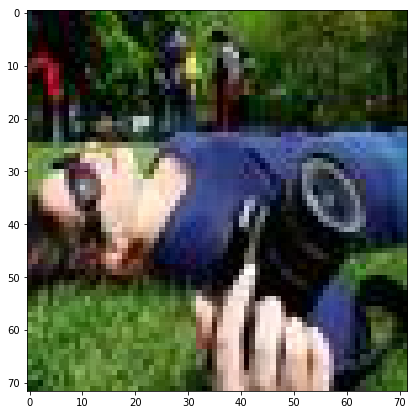

In [72]:
# Original LR image 72x72
k = 56
plt.figure(figsize=(7,7))
plt.imshow(lr_img_array_test[k])
# plt.imsave('images/results/upsampling/lr72x72.jpg', lr_img_array_test[k])

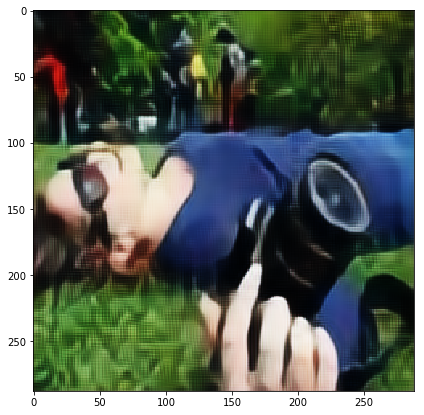

In [73]:
# Generated HR image 288x288
plt.figure(figsize=(7,7))
plt.imshow(p[k].astype('uint8'))
# plt.imsave('images/results/upsampling/gen_hr288x288.jpg', p[k].astype('uint8'))

Create another model that takes 400x400 images and outputs 4x resolution.
This is done by creating a new model, but using the same filter weights as above.
Since the CNN is fully convolutional, we can use it one images of arbitrary size.

In [57]:
def copy_weights(from_layers, to_layers):
    for from_layer,to_layer in zip(from_layers, to_layers):
        to_layer.set_weights(from_layer.get_weights())
        
def get_model(input_shape):
    inp=Input(input_shape)
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Conv2D(3, kernel_size=(9, 9), activation='tanh', padding='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [30]:
inp,outp=get_model(hr_dims)
model_hr = Model(inp, outp)
copy_weights(base_model.layers, model_hr.layers)

In [31]:
# Make Prediction on Test set
hr_img_array_test = []

for file_ in test_files:
    hr_im = Image.open(hr_img_dir + file_)
    hr_img_array_test.append(np.array(hr_im))

In [74]:
hr_img = model_hr.predict(np.array(hr_img_array_test)[k:k+1])

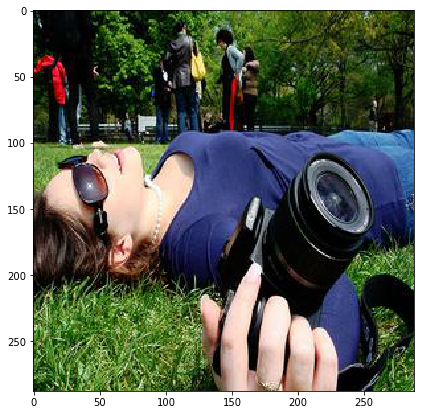

In [75]:
# Original 288x288 image
plt.figure(figsize=(7,7))
plt.imshow(hr_img_array_test[k])
# plt.imsave('images/results/upsampling/hr288x288.jpg', hr_img_array_test[k])

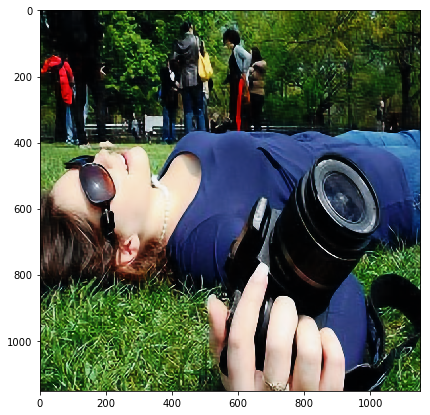

In [76]:
# Generated 1600x1600 image
plt.figure(figsize=(7,7))
plt.imshow(hr_img[0].astype('uint8'))
# plt.imsave('images/results/upsampling/gen_hr1152x1152.jpg', hr_img[0].astype('uint8'))

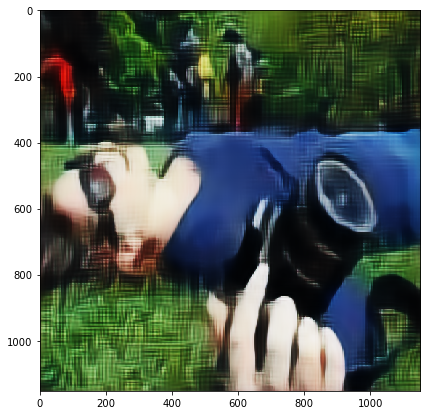

In [77]:
# Generated 1152x1152 image with predicted 288x288 as input [Not so good]!
hr_img_with_base_input = model_hr.predict(p[k:k+1])
plt.figure(figsize=(7,7))
plt.imshow(hr_img_with_base_input[0].astype('uint8'))